In [ ]:
import os
import pickle as pkl
import pandas as pd
import geopandas as gpd
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# Set a fixed random seed for reproducibility
random.seed(19)

# Path to save the final DataFrame
output_pkl_path = "../data/data_final.pkl"
with open(output_pkl_path, "rb") as f:
    gdf = pkl.load(f)
    
to_pred_gdf = gdf.loc[gdf['date'] >= pd.to_datetime('2017-01-01 00:00:00')].reset_index(drop=True)
gdf = gdf.loc[gdf['date'] < pd.to_datetime('2017-01-01 00:00:00')].reset_index(drop=True)

In [ ]:
tiles = gdf['tile_index'].unique().tolist()
random.shuffle(tiles)

train_ratio = 0.8
split_index = int(train_ratio * len(tiles))
train_tiles = tiles[:split_index] 
test_tiles = tiles[split_index:]  

train_gdf = gdf.loc[gdf['tile_index'].isin(train_tiles)]
test_gdf = gdf.loc[gdf['tile_index'].isin(test_tiles)]

X_cols = [col for col in gdf.columns if col.startswith('feature')]
y_col = 'urban_imperviousness'

X_train = train_gdf[X_cols]
y_train = np.stack(train_gdf[y_col].values).reshape(-1, 3, 3) # The target is a 3x3 array (originally a raster tile)

X_test = test_gdf[X_cols]
y_test = np.stack(test_gdf[y_col].values).reshape(-1, 3, 3)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.reshape(-1, 9), dtype=torch.float32)  # Flattened 3x3 grids

X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.reshape(-1, 9), dtype=torch.float32)

In [17]:
print(X_train.values.shape)
print(y_train.shape)

(14289, 768)
(14289, 3, 3)


In [43]:
# Baseline Model

# Calculate the mean urban imperviousness for each cell in the 3x3 grid across the training set
baseline_prediction = np.mean(y_train, axis=0)
print("Baseline prediction (3x3 grid):\n", baseline_prediction)

# Flatten the true and predicted 3x3 grids to apply the metrics for the test set
y_test_flat = y_test.reshape(-1, 9)  # Flatten each 3x3 grid in y_test to a 9-element vector

# Repeat the baseline prediction for each sample in y_test for comparison
baseline_pred = np.tile(baseline_prediction.flatten(), (y_test_flat.shape[0], 1))

# Calculate baseline metrics on the test set
mse_baseline = mean_squared_error(y_test_flat, baseline_pred)
mae_baseline = mean_absolute_error(y_test_flat, baseline_pred)

print(f"Baseline MSE on Test Set: {mse_baseline}")
print(f"Baseline MAE on Test Set: {mae_baseline}")

Baseline prediction (3x3 grid):
 [[0.03153893 0.03276088 0.03203874]
 [0.03237038 0.03245637 0.03228426]
 [0.03272095 0.03256148 0.03270835]]
Baseline MSE on Test Set: 0.004747930448502302
Baseline MAE on Test Set: 0.038547333329916


In [44]:
def train_model(model, X_train_tensor, y_train_tensor, epochs=100, 
                criterion=nn.MSELoss(), optimizer=None, lr=0.001):
    # Default to Adam optimizer if none is provided
    if optimizer is None:
        optimizer = optim.Adam(model.parameters(), lr=lr)
    
    for epoch in range(epochs):
        # Forward pass
        outputs = model(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Print loss every 10 epochs
        if (epoch+1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')
    return model

In [ ]:
# Simple fully connected (dense) neural network 

class SimpleNN(nn.Module):
    def __init__(self, input_size=768, output_size=9, hidden_units=128):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_units)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_units, output_size)  # Output layer matches the size of the 3x3 grid
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = torch.sigmoid(x)  # Apply sigmoid activation to ensure output is in [0, 1]
        return x

# Train the model using the train_model function
simple_nn_model = SimpleNN(input_size=768, output_size=9, hidden_units=128)
trained_simple_nn_model = train_model(
    model=simple_nn_model,  
    X_train_tensor=X_train_tensor,
    y_train_tensor=y_train_tensor,
    epochs=100,  
    criterion=nn.MSELoss(),
    optimizer=optim.Adam(simple_nn_model.parameters(), lr=0.001)
)

# Prediction on test data
with torch.no_grad():
    snn_pred = trained_simple_nn_model(X_test_tensor)

# Calculate metrics
mse_snn = nn.MSELoss()(snn_pred, y_test_tensor).item()
mae_snn = nn.L1Loss()(snn_pred, y_test_tensor).item()

print(f"SimpleNN MSE on Test Set: {mse_snn}")
print(f"SimpleNN MAE on Test Set: {mae_snn}")

Epoch [10/100], Loss: 0.1342
Epoch [20/100], Loss: 0.0395
Epoch [30/100], Loss: 0.0093
Epoch [40/100], Loss: 0.0055
Epoch [50/100], Loss: 0.0052
Epoch [60/100], Loss: 0.0051
Epoch [70/100], Loss: 0.0050
Epoch [80/100], Loss: 0.0048
Epoch [90/100], Loss: 0.0047
Epoch [100/100], Loss: 0.0045
SimpleNN MSE on Test Set: 0.0038124043494462967
SimpleNN MAE on Test Set: 0.03425094112753868


In [68]:
# Deep Fully Connected Neural Network

class DeepNN(nn.Module):
    def __init__(self, input_size=768, output_size=9, hidden_units=128):
        super(DeepNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_units)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_units, hidden_units)
        self.fc3 = nn.Linear(hidden_units, output_size)  # Output layer matches 3x3 grid size

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = torch.sigmoid(x)  # Apply sigmoid activation to ensure output is in [0, 1]
        return x


# Train the model using the train_model function
deep_nn_model = DeepNN(input_size=768, output_size=9, hidden_units=128)
trained_deep_nn_model = train_model(
    model=deep_nn_model,  
    X_train_tensor=X_train_tensor,
    y_train_tensor=y_train_tensor,
    epochs=100, 
    criterion=nn.MSELoss(),
    optimizer=optim.Adam(deep_nn_model.parameters(), lr=0.001)
)

# Prediction on test data
with torch.no_grad():
    dnn_pred = trained_deep_nn_model(X_test_tensor)

# Calculate metrics
mse_dnn = nn.MSELoss()(dnn_pred, y_test_tensor).item()
mae_dnn = nn.L1Loss()(dnn_pred, y_test_tensor).item()

print(f"DeepNN MSE on Test Set: {mse_dnn}")
print(f"DeepNN MAE on Test Set: {mae_dnn}")


Epoch [10/100], Loss: 0.1329
Epoch [20/100], Loss: 0.0101
Epoch [30/100], Loss: 0.0059
Epoch [40/100], Loss: 0.0064
Epoch [50/100], Loss: 0.0064
Epoch [60/100], Loss: 0.0064
Epoch [70/100], Loss: 0.0064
Epoch [80/100], Loss: 0.0063
Epoch [90/100], Loss: 0.0061
Epoch [100/100], Loss: 0.0059
DeepNN MSE on Test Set: 0.004838788881897926
DeepNN MAE on Test Set: 0.028157232329249382


In [69]:
class CNNModel(nn.Module):
    def __init__(self, input_size=768, output_size=9, hidden_units=128):
        super(CNNModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_units)
        self.relu = nn.ReLU()
        self.hidden_units = hidden_units  # Store hidden_units as a class attribute
        self.output_size = output_size  # Store output_size as a class attribute

        # Define a Conv1d layer
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=16, kernel_size=3, stride=1)
        
        # Second fully connected layer to project to the output size
        conv_out_size = (hidden_units - 3 + 1) * 16  # Calculating the output size of conv layer
        self.fc2 = nn.Linear(conv_out_size, output_size)

    def forward(self, x):
        # Fully connected layer followed by ReLU activation
        x = self.fc1(x)
        x = self.relu(x)
        # Reshape to match Conv1d input shape (batch_size, channels, sequence_length)
        x = x.view(-1, 1, self.hidden_units)
        # Convolutional layer followed by flattening
        x = self.conv1(x)
        x = x.view(x.size(0), -1)  # Flatten before passing to the output layer
        # Fully connected and sigmoid activation for output
        x = self.fc2(x)
        x = torch.sigmoid(x)  # Apply sigmoid activation to ensure output is in [0, 1]
        return x


# Train the model using the train_model function
cnn_model = CNNModel(input_size=768, output_size=9, hidden_units=128)
trained_cnn_model = train_model(
    model=cnn_model,  
    X_train_tensor=X_train_tensor,
    y_train_tensor=y_train_tensor,
    epochs=100,
    criterion=nn.MSELoss(),
    optimizer=optim.Adam(cnn_model.parameters(), lr=0.001)
)

# Prediction on test data
with torch.no_grad():
    cnn_pred = trained_cnn_model(X_test_tensor)

# Calculate metrics
mse_cnn = nn.MSELoss()(cnn_pred, y_test_tensor).item()
mae_cnn = nn.L1Loss()(cnn_pred, y_test_tensor).item()

print(f"CNN MSE on Test Set: {mse_cnn}")
print(f"CNN MAE on Test Set: {mae_cnn}")


Epoch [10/100], Loss: 0.0058
Epoch [20/100], Loss: 0.0065
Epoch [30/100], Loss: 0.0066
Epoch [40/100], Loss: 0.0067
Epoch [50/100], Loss: 0.0067
Epoch [60/100], Loss: 0.0067
Epoch [70/100], Loss: 0.0067
Epoch [80/100], Loss: 0.0067
Epoch [90/100], Loss: 0.0066
Epoch [100/100], Loss: 0.0066
CNN MSE on Test Set: 0.005420705769211054
CNN MAE on Test Set: 0.029209798201918602


In [70]:
class LSTMModel(nn.Module):
    def __init__(self, input_size=768, output_size=9, hidden_units=128, lstm_layers=1):
        super(LSTMModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_units)
        self.relu = nn.ReLU()
        self.lstm = nn.LSTM(input_size=hidden_units, hidden_size=hidden_units, num_layers=lstm_layers, batch_first=True)
        self.fc2 = nn.Linear(hidden_units, output_size)

    def forward(self, x):
        # First fully connected layer
        x = self.fc1(x)
        x = self.relu(x)
        # Reshape for LSTM: (batch_size, sequence_length, input_size)
        x = x.unsqueeze(1)  # Adding a sequence dimension, shape becomes (batch_size, 1, hidden_units)
        # LSTM layer
        lstm_out, _ = self.lstm(x)
        # Take the output of the last LSTM cell
        x = lstm_out[:, -1, :]
        # Final fully connected layer and sigmoid activation
        x = self.fc2(x)
        x = torch.sigmoid(x)  # Apply sigmoid activation to ensure output is in [0, 1]
        return x

# Initialize the LSTM model
lstm_model = LSTMModel(input_size=768, output_size=9, hidden_units=128, lstm_layers=1)

# Train the model using the `train_model` function
trained_lstm_model = train_model(
    model=lstm_model,  
    X_train_tensor=X_train_tensor,
    y_train_tensor=y_train_tensor,
    epochs=100,
    criterion=nn.MSELoss(),
    optimizer=optim.Adam(lstm_model.parameters(), lr=0.001)
)

# Prediction on test data
with torch.no_grad():
    lstm_pred = trained_lstm_model(X_test_tensor)

# Calculate metrics
mse_lstm = nn.MSELoss()(lstm_pred, y_test_tensor).item()
mae_lstm = nn.L1Loss()(lstm_pred, y_test_tensor).item()

print(f"LSTM MSE on Test Set: {mse_lstm}")
print(f"LSTM MAE on Test Set: {mae_lstm}")


Epoch [10/100], Loss: 0.1765
Epoch [20/100], Loss: 0.0403
Epoch [30/100], Loss: 0.0064
Epoch [40/100], Loss: 0.0056
Epoch [50/100], Loss: 0.0057
Epoch [60/100], Loss: 0.0058
Epoch [70/100], Loss: 0.0058
Epoch [80/100], Loss: 0.0057
Epoch [90/100], Loss: 0.0057
Epoch [100/100], Loss: 0.0056
LSTM MSE on Test Set: 0.004583938512951136
LSTM MAE on Test Set: 0.03372175619006157


In [71]:
# Calculate RMSE for each model
rmse_baseline = np.sqrt(mse_baseline)
rmse_snn = np.sqrt(mse_snn)
rmse_dnn = np.sqrt(mse_dnn)
rmse_cnn = np.sqrt(mse_cnn)
rmse_lstm = np.sqrt(mse_lstm)

# Create a summary table
metrics_summary = pd.DataFrame({
    'Model': ['Baseline', 'SimpleNN', 'DeepNN', 'CNN', 'LSTM'],
    'MSE': [mse_baseline, mse_snn, mse_dnn, mse_cnn, mse_lstm],
    'RMSE': [rmse_baseline, rmse_snn, rmse_dnn, rmse_cnn, rmse_lstm],
    'MAE': [mae_baseline, mae_snn, mae_dnn, mae_cnn, mae_lstm]
})
print(metrics_summary)


      Model       MSE      RMSE       MAE
0  Baseline  0.004748  0.068905  0.038547
1  SimpleNN  0.003812  0.061745  0.034251
2    DeepNN  0.004839  0.069561  0.028157
3       CNN  0.005421  0.073625  0.029210
4      LSTM  0.004584  0.067705  0.033722


<module 'matplotlib.pyplot' from 'c:\\Users\\btripp\\urban-clay\\env\\Lib\\site-packages\\matplotlib\\pyplot.py'>

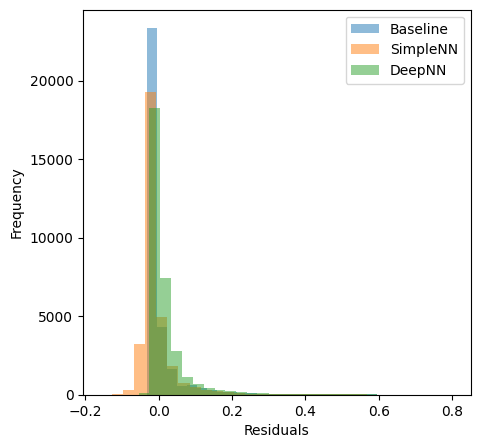

In [74]:
# Flatten predictions and ground truth for residual analysis
def res_plot(y_tensor, yhat_tensors, labels, title="", figsize=(5, 5), bins=30, alpha=0.5):
    # Plot histograms of residuals
    plt.figure(figsize=figsize)

    for yhat_tensor, label in zip(yhat_tensors, labels):
        y_flat = y_tensor.numpy().reshape(-1)
        if type(yhat_tensor) == torch.Tensor:
            yhat_flat = yhat_tensor.numpy().reshape(-1)
        else:
            yhat_flat = yhat_tensor.reshape(-1)
        # Calculate residuals
        residuals = y_flat - yhat_flat
        plt.hist(residuals, bins=bins, alpha=alpha, label=label)
    plt.xlabel('Residuals')
    plt.ylabel('Frequency')
    plt.legend()
    plt.title(title)
    return plt

res_plot(y_test_tensor, [baseline_pred, snn_pred, dnn_pred], ["Baseline", "SimpleNN", "DeepNN"])

In [73]:
snn_pred

tensor([[0.0280, 0.0208, 0.0194,  ..., 0.0287, 0.0259, 0.0319],
        [0.0294, 0.0224, 0.0204,  ..., 0.0302, 0.0276, 0.0333],
        [0.0275, 0.0205, 0.0188,  ..., 0.0290, 0.0255, 0.0314],
        ...,
        [0.0264, 0.0208, 0.0192,  ..., 0.0273, 0.0244, 0.0315],
        [0.0393, 0.0301, 0.0285,  ..., 0.0395, 0.0369, 0.0486],
        [0.0463, 0.0367, 0.0347,  ..., 0.0473, 0.0428, 0.0555]])